# Super Simple DDPM on MNIST - Just an MLP!

This notebook uses the **simplest possible** diffusion model:
- Just a 3-layer MLP (Multi-Layer Perceptron)
- ~500K parameters instead of millions
- Trains in ~10 minutes
- **Actually works on MNIST!**

No U-Net, no convolutions, no attention - just the basics.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import NoiseScheduler, SimpleMLP

## Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

print(f"Using device: {device}")

config = {
    'image_size': 28,  # Keep MNIST at original size
    'batch_size': 128,
    'num_epochs': 30,  # More epochs since model is simple
    'learning_rate': 1e-3,  # Can use higher LR for MLP
    'num_timesteps': 1000,
}

os.makedirs('outputs/mnist_simple/samples', exist_ok=True)

Using device: mps


## Load MNIST

Training samples: 60000


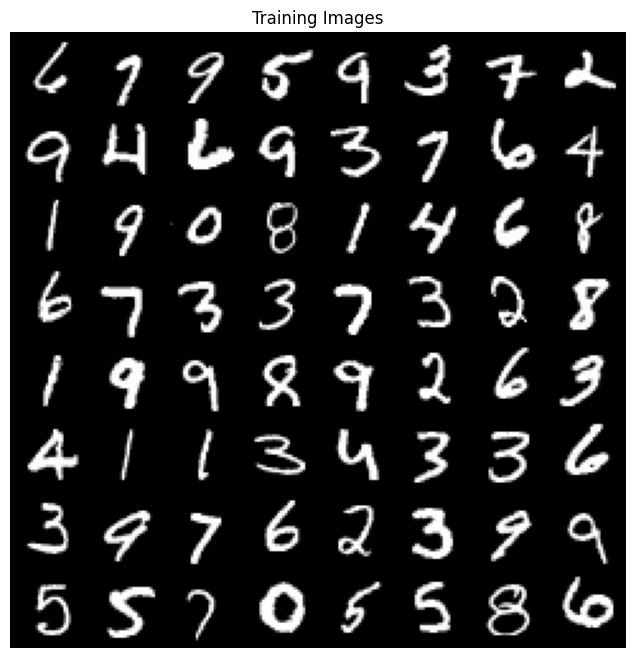

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

print(f"Training samples: {len(train_dataset)}")

# Show examples
sample_batch, _ = next(iter(train_loader))
grid = make_grid(sample_batch[:64], nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
plt.title('Training Images')
plt.show()

## Initialize Simple MLP Model

In [4]:
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=0.0001,
    beta_end=0.02,
    schedule_type='linear',
    device=device
)

# Simple MLP - just 3 hidden layers!
model = SimpleMLP(
    image_size=28,
    hidden_dim=512,
    time_emb_dim=128
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"\nModel architecture:")
print(model)

Model parameters: 1,411,472

Model architecture:
SimpleMLP(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU()
  )
  (mlp): Sequential(
    (0): Linear(in_features=912, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)


## Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.MSELoss()

losses = []
model.train()

for epoch in range(config['num_epochs']):
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    
    for images, _ in progress_bar:
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Sample timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add noise
        noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise
        predicted_noise = model(noisy_images, t)
        
        # Loss
        loss = criterion(predicted_noise, noise)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.6f}")

print("\nTraining complete!")

Epoch 1/30: 100%|██████████| 469/469 [00:05<00:00, 81.63it/s, loss=0.7540] 


Epoch 1 - Avg Loss: 0.830653


Epoch 2/30:  22%|██▏       | 104/469 [00:01<00:03, 110.80it/s, loss=0.7217]

## Plot Loss

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.4)
plt.plot(np.convolve(losses, np.ones(50)/50, mode='valid'), linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Raw', 'Smoothed'])
plt.grid(True, alpha=0.3)
plt.show()

## Generate Samples

In [ ]:
@torch.no_grad()
def sample(num_samples=64):
    model.eval()
    
    # Start from pure noise
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Denoise step by step
    for t in tqdm(reversed(range(noise_scheduler.num_timesteps)), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get scheduler values
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        # Add noise if not last step
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        # Denoise
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + torch.sqrt(beta) * noise
    
    model.train()
    return x

# Generate
samples = sample(64)

# Visualize
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated MNIST Digits (Simple MLP)')
plt.savefig('outputs/mnist_simple/samples/final_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualize Denoising Process

In [ ]:
@torch.no_grad()
def sample_with_steps(num_samples=8, steps_to_show=10):
    model.eval()
    
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    timesteps = list(reversed(range(noise_scheduler.num_timesteps)))
    step_interval = len(timesteps) // steps_to_show
    saved_steps = []
    
    for i, t in enumerate(tqdm(timesteps, desc='Denoising')):
        if i % step_interval == 0 or i == len(timesteps) - 1:
            saved_steps.append(x.cpu().clone())
        
        t_batch = torch.tensor([t] * num_samples, device=device)
        predicted_noise = model(x, t_batch)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + torch.sqrt(beta) * noise
    
    model.train()
    return saved_steps

steps = sample_with_steps(8, 10)

# Plot
fig, axes = plt.subplots(8, len(steps), figsize=(15, 10))
for i in range(8):
    for j, step_imgs in enumerate(steps):
        axes[i, j].imshow(step_imgs[i, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'Step {j}')

plt.suptitle('Denoising Process: Noise → Digit', fontsize=14)
plt.tight_layout()
plt.savefig('outputs/mnist_simple/samples/denoising_process.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Takeaways

**This simple MLP proves:**
1. You DON'T need U-Nets for simple datasets
2. A basic 3-layer MLP with ~500K params works fine on MNIST
3. Much faster to train and easier to understand
4. Good for learning and experimentation

**When to use what:**
- **SimpleMLP**: MNIST, simple datasets, fast experiments
- **SimpleCNN**: Better quality on MNIST, still fast
- **U-Net**: Real images (CelebA, ImageNet, etc.)

**If you're getting maze patterns:**
- Train for more epochs (30-50)
- Check your data normalization (should be [-1, 1])
- Lower learning rate if loss explodes
- SimpleMLP is less prone to artifacts than U-Net!